# Nonnegative Matrix Factorization Testing

Some tests with the nonnegative matrix factorization code and the Scikit-learn package

In [20]:
import sys
import logging
from imp import reload
import numpy as np
import seaborn.apionly as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import NMF
sys.path.append('/home/wtb2/Documents/solarnmf/src/')
import solarnmf_learn as snl
import solarnmf_plotting as snp
import solarnmf_observations as sno
reload(snl)
reload(snp)
reload(sno)

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'solarnmf_observations' from '/home/wtb2/Documents/solarnmf/src/solarnmf_observations.py'>

In [2]:
#set logging to debug
ntbk_logger = logging.getLogger()
ntbk_logger.level = logging.DEBUG

## Matrices: two-dimensional tests

First, we will use the solarNMF code to generate some sample observations.

In [3]:
obs = sno.MakeData('simulation','matrix',p=5,nx=100,ny=100,ngrid_x=20,ngrid_y=20)

INFO:MakeData:Setting nx = 100
INFO:MakeData:Setting ny = 100
INFO:MakeData:Setting p = 5


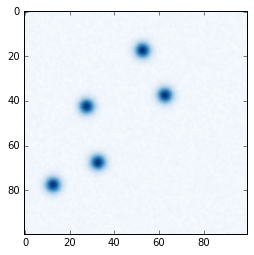

In [7]:
target,T = obs.make_t_matrix()
plt.imshow(T,cmap='Blues')

Now try to use scikit-learn to do the NMF decomposition.

In [8]:
model = NMF(n_components=5,init='random',random_state=0,verbose=0,alpha=0,l1_ratio=1e-7)

In [9]:
U = model.fit_transform(T)
V = model.components_
A = np.dot(U,V)
print('(%d,%d), (%d,%d), (%d,%d)'%(np.shape(A)[0],np.shape(A)[1],np.shape(U)[0],np.shape(U)[1],
                                   np.shape(V)[0],np.shape(V)[1]))
print('error = %f'%model.reconstruction_err_)

(100,100), (100,5), (5,100)
error = 1.796129


Use our plotter function to plot the results.

In [21]:
plotter = snp.MakeBSSPlots('simulation','matrix',U,V,A,T,target=target)

INFO:MakeBSSPlots:Finding peaks from separated images
DEBUG:MakeBSSPlots:(43,27)
DEBUG:MakeBSSPlots:(77,12)
DEBUG:MakeBSSPlots:(68,33)
DEBUG:MakeBSSPlots:(17,52)
DEBUG:MakeBSSPlots:(37,62)


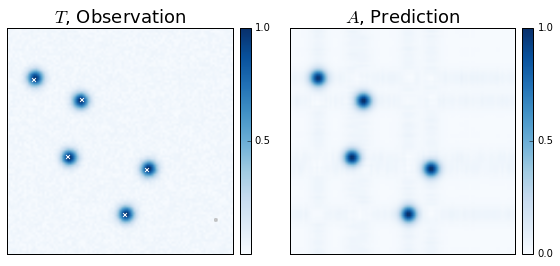

In [22]:
plotter.plot_obs_pred_total(peak_id=True)

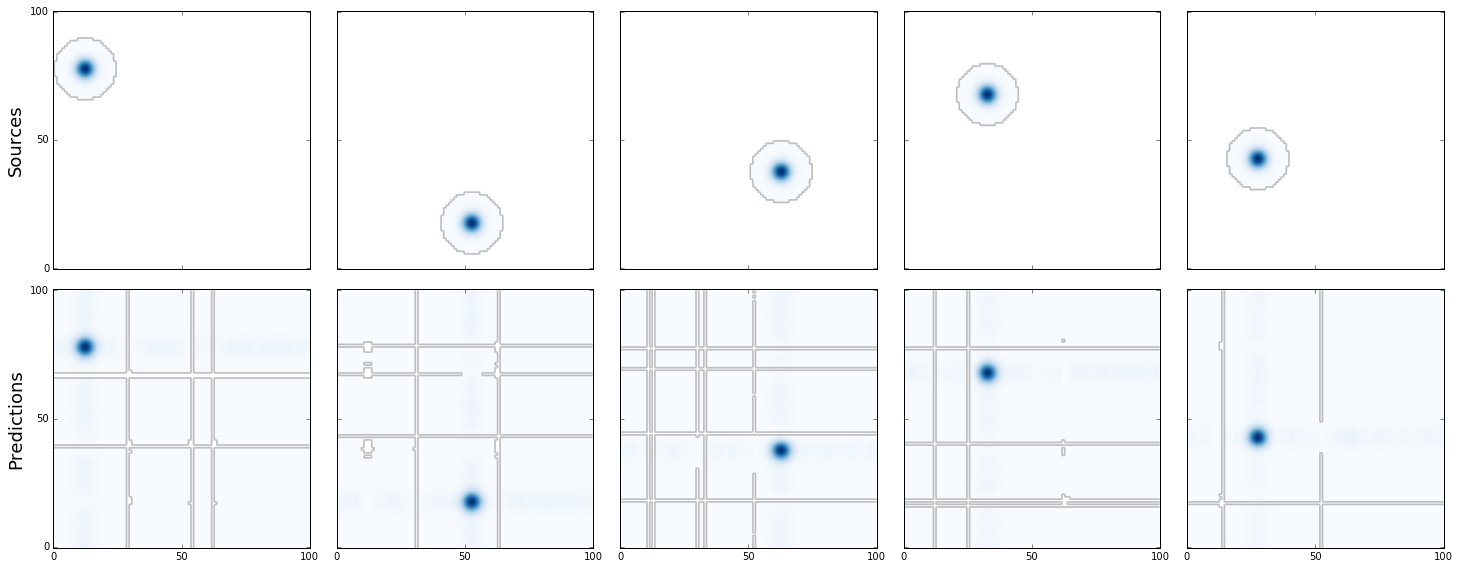

In [23]:
plotter.fig_size = (4*max(plotter.q,len(plotter.target)),4*2)
plotter.plot_obs_pred_sources()

Here, it's obvious that NMF does a good job of picking out the individual sources because we have guessed the correct number of sources. However, we want to be able to estimate the true number of sources and not overfit our model.

Let's try searching $(\alpha,\ell_1)$ space for the best values of these parameters.

In [24]:
alpha_guess = np.linspace(0,3.5,10)
l1_guess = np.linspace(0,1,10)

In [25]:
div_mat = np.zeros([len(alpha_guess),len(l1_guess)])
iters_mat = np.zeros([len(alpha_guess),len(l1_guess)])

In [26]:
for i in range(len(alpha_guess)):
    for j in range(len(l1_guess)):
        model = NMF(n_components=7,init='random',random_state=0,alpha=alpha_guess[i],l1_ratio=l1_guess[j],
                    max_iter=5000,verbose=0,shuffle=True)
        model.fit(T)
        div_mat[i,j] = model.reconstruction_err_
        iters_mat[i,j] = model.n_iter_

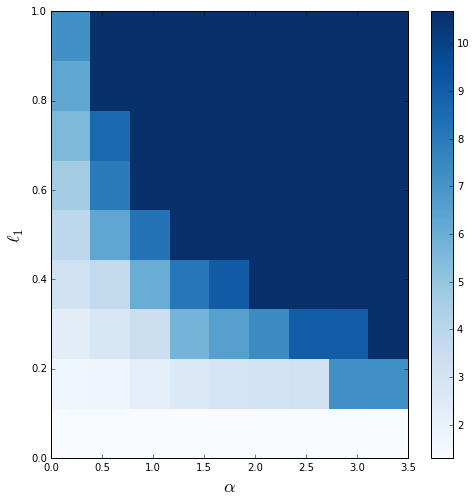

In [27]:
Alpha,L1 = np.meshgrid(alpha_guess,l1_guess)
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
surf=ax.pcolormesh(Alpha,L1,div_mat,cmap=plt.cm.Blues)
ax.set_ylim([np.min(l1_guess),np.max(l1_guess)])
ax.set_xlim([np.min(alpha_guess),np.max(alpha_guess)])
ax.set_ylabel(r'$\ell_1$',fontsize=18)
ax.set_xlabel(r'$\alpha$',fontsize=18)
fig.colorbar(surf,ax=ax)
plt.show()

Since $\ell_1$ controls the sparseness and we are really interested in the smoothness parameter ($\alpha$) here, let's fix $\ell_1=0.5$ (balance between $L_1$ and $L_2$ penalty terms).

Now, let's try several different guesses for the number of sources and plot the resulting error.

In [28]:
sources_guess = np.arange(1,20,1)
div = []
iters = []
for sg in sources_guess:
    model = NMF(n_components=int(sg),init='random',random_state=0,alpha=1.5,l1_ratio=0.2,max_iter=5000,verbose=0,
               shuffle=True)
    u = model.fit_transform(T)
    div.append(model.reconstruction_err_)
    iters.append(model.n_iter_)

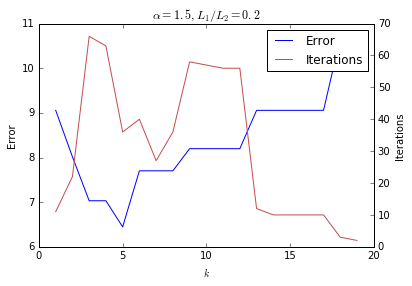

In [29]:
fig = plt.figure()
ax = fig.gca()
ax2 = ax.twinx()
line1 = ax.plot(sources_guess,div,label=r'Error')
line2 = ax2.plot(sources_guess,iters,color=sns.color_palette('deep')[2],label=r'Iterations')
lines = line1 + line2
labels = []
[labels.append(l.get_label()) for l in lines]
ax.set_ylabel(r'Error')
ax2.set_ylabel(r'Iterations')
ax.set_xlabel(r'$k$')
ax.set_title(r'$\alpha=1.5, L_1/L_2=0.2$')
ax2.legend(lines,labels)

Note that the error curve as a function of guessed $k$ in this case has a minimum near $k=5$, indicating that this number of sources is the best fit to the model. Because the error increases at large $k$, we seem to not be overfitting.

What if we turn off the smoothing parameter $\alpha$?

In [30]:
div_a0 = []
iters_a0 = []
for sg in sources_guess:
    model = NMF(n_components=int(sg),init='random',random_state=0,alpha=0.0,l1_ratio=0.2,max_iter=5000,verbose=0,
               shuffle=True)
    u = model.fit_transform(T)
    div_a0.append(model.reconstruction_err_)
    iters_a0.append(model.n_iter_)

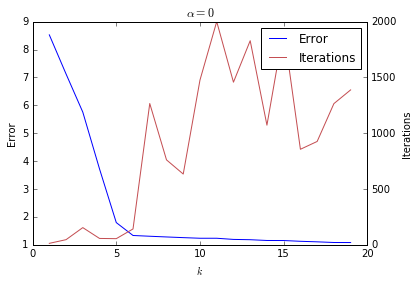

In [31]:
fig = plt.figure()
ax = fig.gca()
ax2 = ax.twinx()
line1 = ax.plot(sources_guess,div_a0,label=r'Error')
line2 = ax2.plot(sources_guess,iters_a0,color=sns.color_palette('deep')[2],label=r'Iterations')
lines = line1 + line2
labels = []
[labels.append(l.get_label()) for l in lines]
ax.set_ylabel(r'Error')
ax2.set_ylabel(r'Iterations')
ax.set_xlabel(r'$k$')
ax.set_title(r'$\alpha=0$')
ax2.legend(lines,labels)

By turning off the smoothness parameter, we allow for overfitting: as $k\to\infty$, the error in our model fit goes to 0.

## Time series: one-dimensional tests